# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_multiome`

ArchR preprocessing script: https://github.com/settylab/Lab-wiki/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [1]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [2]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [4]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [5]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [6]:
data_dir = os.path.expanduser('/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_multiome/ArchR/pbmc_multiome_atac/export/')

Load all the exported results from ArchR

### Peaks data

In [7]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [8]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()

,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,nearestGene,distToGeneStart,peakType,distToTSS,nearestTSS,GC,idx
chr1:817085-817585,chr1,817085,817585,501,*,14.11180,0.915,0.799,2,C3._.Rep2,FAM87B,36,Promoter,35,uc057aum.1,0.4790,1
chr1:827300-827800,chr1,827300,827800,501,*,26.96050,0.989,0.969,2,C5._.Rep2,LINC01128,2412,Promoter,27,uc057auo.1,0.6886,2
chr1:842502-843002,chr1,842502,843002,501,*,3.24257,0.345,0.074,2,C10._.Rep2,LINC01128,17614,Intronic,8595,uc057auo.1,0.5828,3
chr1:844401-844901,chr1,844401,844901,501,*,7.35749,0.776,0.518,2,C12._.Rep2,LINC01128,19513,Intronic,6696,uc057auo.1,0.5190,4
chr1:857886-858386,chr1,857886,858386,501,*,7.32981,0.762,0.501,2,C7._.Rep2,LINC01128,32998,Exonic,6787,uc057auo.1,0.3772,5


In [9]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

In [10]:
ad.X = ad.X.tocsr()

In [11]:
ad

AnnData object with n_obs × n_vars = 9851 × 154294
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'

### SVD

In [12]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [13]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [14]:
ad

AnnData object with n_obs × n_vars = 9851 × 154294
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    obsm: 'X_svd'

### Gene scores

In [15]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [16]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [17]:
ad

AnnData object with n_obs × n_vars = 9851 × 154294
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

# Preprocessing

In [18]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

In [19]:
# Phenograph
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.1112565994262695 seconds
Jaccard graph constructed in 3.992753744125366 seconds
Wrote graph to binary file in 1.899702787399292 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.857378
After 4 runs, maximum modularity is Q = 0.858832
After 22 runs, maximum modularity is Q = 0.859916
Louvain completed 42 runs in 20.765809059143066 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 32.40204739570618 seconds


In [20]:
# Diffusion maps
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors']  = dm_res['EigenVectors'].values
ad.uns['DM_EigenValues']  = dm_res['EigenValues'].values

Determing nearest neighbor graph...


In [21]:
# Force directed layout
ad.obsm['X_FDL'] = harmony.plot.force_directed_layout(dm_res['kernel']).values

100%|██████████| 500/500 [01:48<00:00,  4.60it/s]

BarnesHut Approximation  took  50.45  seconds
Repulsion forces  took  49.93  seconds
Gravitational forces  took  0.52  seconds
Attraction forces  took  3.21  seconds
AdjustSpeedAndApplyForces step  took  2.20  seconds


# Visualizations

... storing 'Sample' as categorical
... storing 'Clusters' as categorical
... storing 'phenograph' as categorical
... storing 'seqnames' as categorical
... storing 'strand' as categorical
... storing 'GroupReplicate' as categorical
... storing 'nearestGene' as categorical
... storing 'peakType' as categorical
... storing 'nearestTSS' as categorical


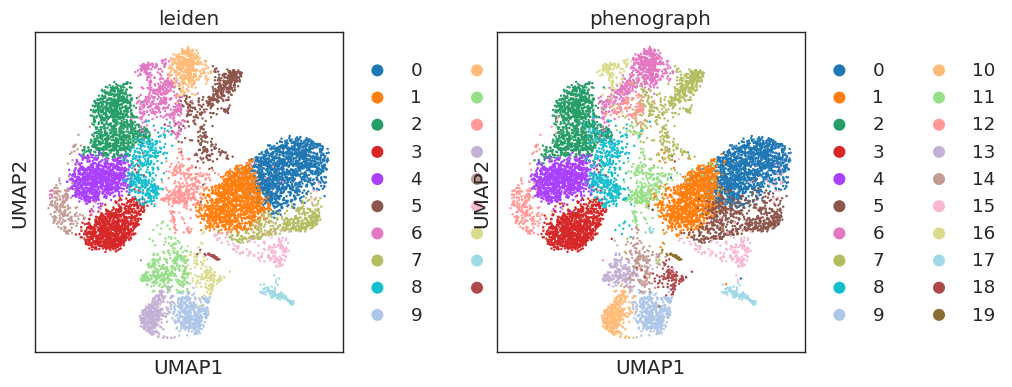

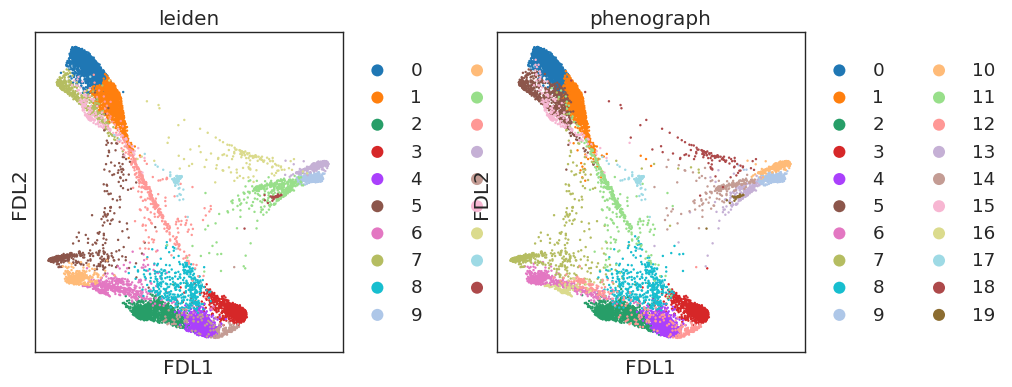

In [22]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])
sc.pl.scatter(ad, basis='FDL', color=['leiden', 'phenograph'])

# Save

In [23]:
ad

AnnData object with n_obs × n_vars = 9851 × 154294
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'GeneScoresColums', 'neighbors', 'umap', 'leiden', 'DM_EigenValues', 'leiden_colors', 'phenograph_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap', 'DM_EigenVectors', 'X_FDL'
    obsp: 'distances', 'connectivities', 'DM_kernel'

In [28]:
ad.write(data_dir + '../../../pbmc_multiome_atac.h5ad')